In [1]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_reports.json to synthetic_reports (2).json


In [2]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install wordcloud
!pip install plotly

In [3]:
!pip install -U "transformers>=4.40" "accelerate>=0.30" datasets evaluate -q
import transformers
print(transformers.__version__)  # sanity check, should show a recent 4.x

4.55.3


In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    TrainingArguments,
    Trainer,
    pipeline
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [7]:
def load_synthetic_data():
    """Load the synthetic trip reports data"""
    # You'll upload your synthetic_reports.json to Colab
    with open('synthetic_reports.json', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    return df

def explore_data(df):
    """Comprehensive data exploration"""
    print("=== DATASET OVERVIEW ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\n=== MISSING VALUES ===")
    print(df.isnull().sum())

    print("\n=== SUBSTANCE DISTRIBUTION ===")
    substance_counts = df['substance'].value_counts()
    print(substance_counts)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Substance distribution
    substance_counts.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Substance Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Experience type distribution
    df['experience_type'].value_counts().plot(kind='pie', ax=axes[0,1])
    axes[0,1].set_title('Experience Type Distribution')

    # Intensity distribution
    df['intensity'].value_counts().plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Intensity Distribution')

    # Text length distribution
    df['text_length'] = df['experience_text'].str.len()
    df['text_length'].hist(bins=30, ax=axes[1,1])
    axes[1,1].set_title('Text Length Distribution')
    axes[1,1].set_xlabel('Characters')

    plt.tight_layout()
    plt.show()

    # Word cloud of experience texts
    all_text = ' '.join(df['experience_text'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Experience Reports')
    plt.show()

    return df

In [8]:
def preprocess_for_classification(df):
    """Prepare data for classification tasks"""

    # Create different classification tasks
    classification_tasks = {}

    # Task 1: Experience Type Classification
    classification_tasks['experience_type'] = {
        'texts': df['experience_text'].tolist(),
        'labels': df['experience_type'].tolist(),
        'task_name': 'Experience Type Classification'
    }

    # Task 2: Intensity Classification
    classification_tasks['intensity'] = {
        'texts': df['experience_text'].tolist(),
        'labels': df['intensity'].tolist(),
        'task_name': 'Intensity Classification'
    }

    # Task 3: Substance Classification
    classification_tasks['substance'] = {
        'texts': df['experience_text'].tolist(),
        'labels': df['substance'].tolist(),
        'task_name': 'Substance Classification'
    }

    return classification_tasks

def create_datasets(texts, labels, tokenizer, max_length=512):
    """Create train/val/test datasets"""

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )

    # Tokenize
    def tokenize_function(examples):
        return tokenizer(examples['text'], truncation=True, padding=True, max_length=max_length)

    # Create datasets
    train_dataset = Dataset.from_dict({'text': X_train, 'labels': y_train})
    val_dataset = Dataset.from_dict({'text': X_val, 'labels': y_val})
    test_dataset = Dataset.from_dict({'text': X_test, 'labels': y_test})

    # Tokenize
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    return {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset,
        'label_encoder': label_encoder
    }

In [9]:
def train_classification_model(datasets, model_name='distilbert-base-uncased', num_labels=None):
    """Train a classification model"""

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    import os
    os.environ["WANDB_DISABLED"] = "true"

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=None,  # Disable wandb
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets['train'],
        eval_dataset=datasets['val'],
        tokenizer=tokenizer,
    )

    # Train
    print("Starting training...")
    trainer.train()

    return trainer, tokenizer

def evaluate_classification_model(trainer, test_dataset, label_encoder):
    """Evaluate the trained model"""

    # Predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Decode labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_true)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_labels, y_pred_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return y_pred_labels, y_true_labels


In [10]:
def prepare_summarization_data(df):
    """Prepare data for summarization"""

    # Create summaries from first few sentences for training
    def create_summary(text):
        sentences = text.split('. ')
        if len(sentences) >= 3:
            return '. '.join(sentences[:2]) + '.'
        return text

    # For now, create extractive summaries as targets
    df['summary'] = df['experience_text'].apply(create_summary)

    # Filter out very short texts
    df_summary = df[df['experience_text'].str.len() > 200].copy()

    return df_summary

def train_summarization_model(df_summary, model_name='t5-small'):
    """Train or fine-tune a summarization model"""

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # Prepare data
    inputs = ["summarize: " + text for text in df_summary['experience_text']]
    targets = df_summary['summary'].tolist()

    # Split data
    train_inputs, test_inputs, train_targets, test_targets = train_test_split(
        inputs, targets, test_size=0.2, random_state=42
    )

    # Tokenize
    def tokenize_function(examples):
        model_inputs = tokenizer(examples['input_text'], max_length=512, truncation=True, padding=True)
        labels = tokenizer(examples['target_text'], max_length=128, truncation=True, padding=True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    # Create datasets
    train_dataset = Dataset.from_dict({'input_text': train_inputs, 'target_text': train_targets})
    test_dataset = Dataset.from_dict({'input_text': test_inputs, 'target_text': test_targets})

    train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['input_text', 'target_text'])
    test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['input_text', 'target_text'])

    import os
    os.environ["WANDB_DISABLED"] = "true"

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./summarization_results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir='./logs',
        report_to=None,
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )

    # Train
    print("Training summarization model...")
    trainer.train()

    return trainer, tokenizer


In [11]:
def create_inference_pipelines(classification_trainers, summarization_trainer):
    """Create inference pipelines for easy testing"""

    pipelines = {}

    # Classification pipelines
    for task_name, trainer in classification_trainers.items():
        pipelines[f'{task_name}_classifier'] = pipeline(
            "text-classification",
            model=trainer.model,
            tokenizer=trainer.tokenizer,
            device=0 if torch.cuda.is_available() else -1
        )

    # Summarization pipeline
    if summarization_trainer:
        pipelines['summarizer'] = pipeline(
            "summarization",
            model=summarization_trainer.model,
            tokenizer=summarization_trainer.tokenizer,
            device=0 if torch.cuda.is_available() else -1
        )

    return pipelines

def analyze_results(df, pipelines):
    """Analyze results and create insights"""

    print("=== MODEL ANALYSIS ===")

    # Test on sample texts
    sample_texts = df['experience_text'].sample(5).tolist()

    for i, text in enumerate(sample_texts):
        print(f"\n--- Sample {i+1} ---")
        print(f"Original text (first 200 chars): {text[:200]}...")

        # Classification results
        if 'experience_type_classifier' in pipelines:
            result = pipelines['experience_type_classifier'](text)
            print(f"Predicted experience type: {result[0]['label']} (confidence: {result[0]['score']:.3f})")

        # Summarization result
        if 'summarizer' in pipelines:
            summary = pipelines['summarizer'](text, max_length=50, min_length=10)
            print(f"Summary: {summary[0]['summary_text']}")

In [12]:
import transformers
print(transformers.__file__)


/usr/local/lib/python3.12/dist-packages/transformers/__init__.py


🚀 Starting Trip Report NLP Pipeline
=== DATASET OVERVIEW ===
Dataset shape: (200, 12)
Columns: ['report_id', 'substance', 'experience_type', 'intensity', 'experience_text', 'age', 'weight', 'dosage', 'duration', 'setting', 'generated_at', 'data_source']

=== MISSING VALUES ===
report_id          0
substance          0
experience_type    0
intensity          0
experience_text    0
age                0
weight             0
dosage             0
duration           0
setting            0
generated_at       0
data_source        0
dtype: int64

=== SUBSTANCE DISTRIBUTION ===
substance
Mescaline     27
Ayahuasca     25
Psilocybin    25
MDMA          24
Cannabis      21
LSD           21
2C-B          20
Ketamine      20
DMT           17
Name: count, dtype: int64


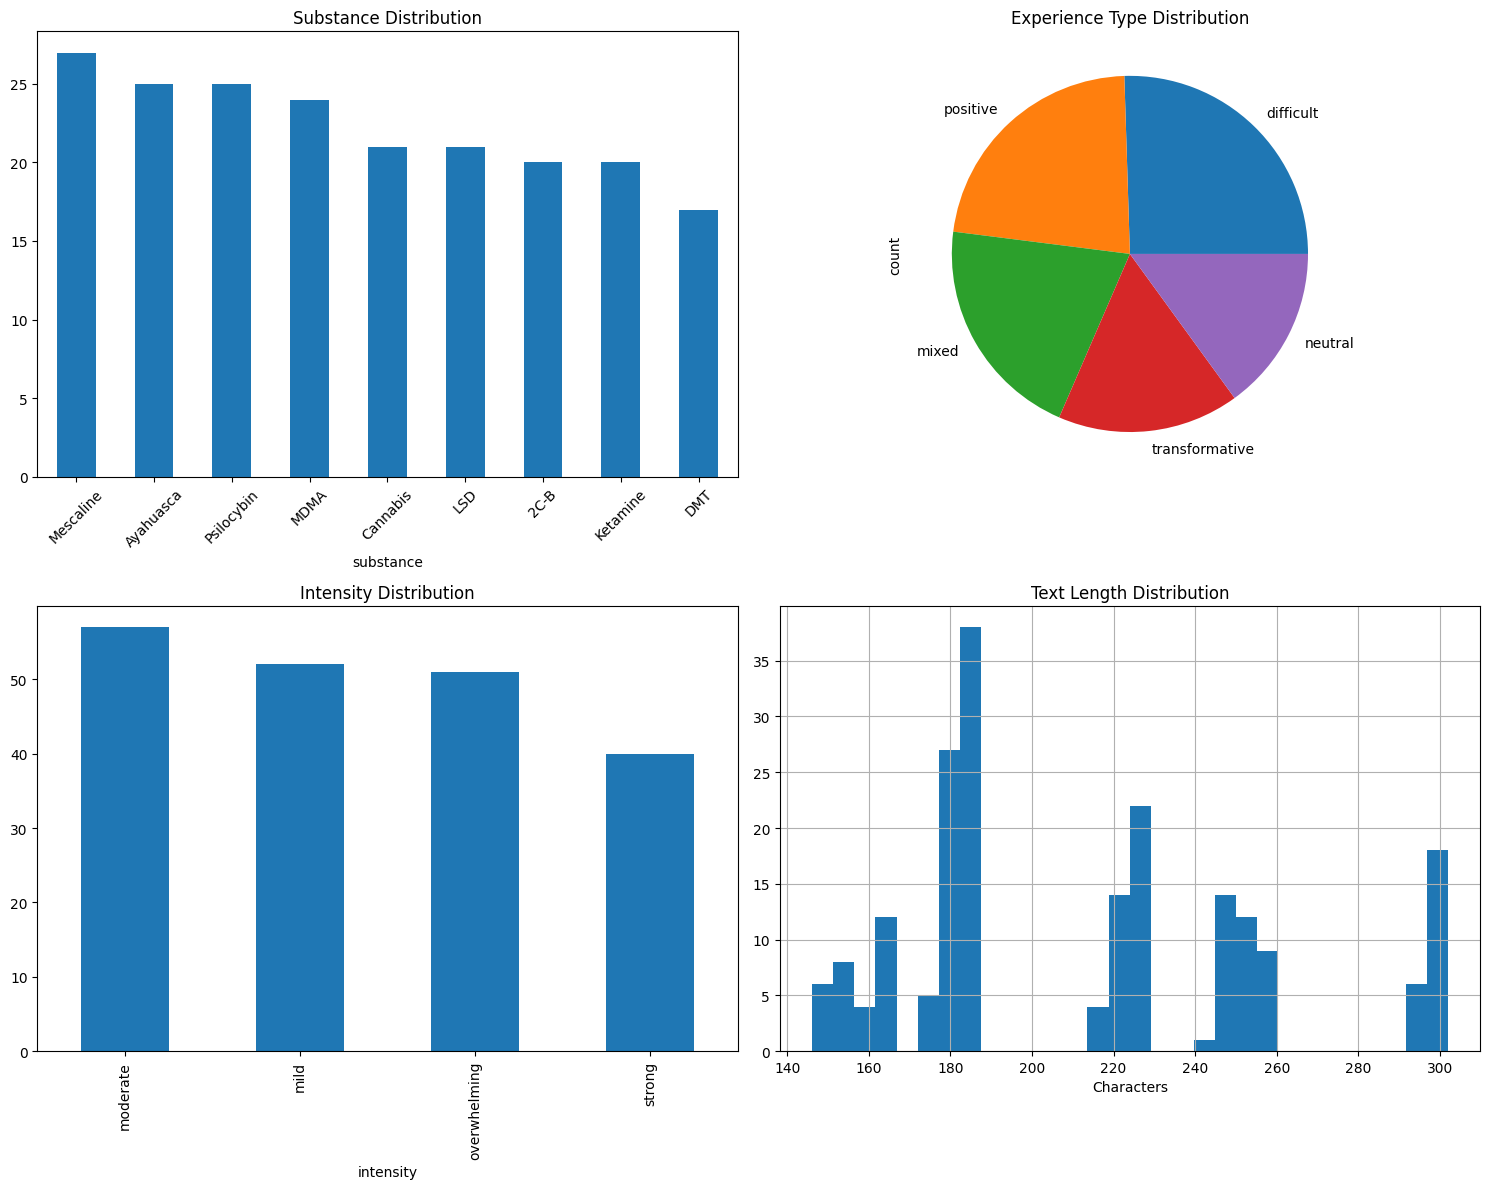

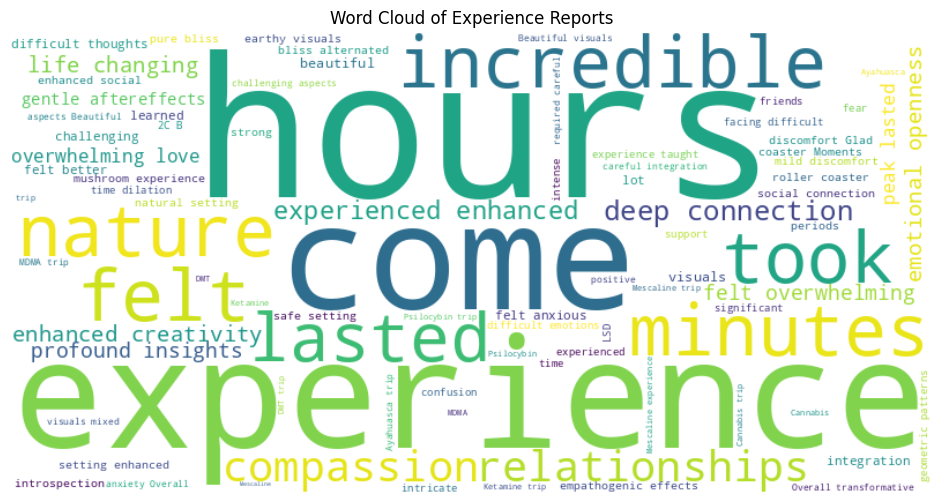


🔄 Training Experience Type Classification...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2962733134.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,1.618500
20,1.587700


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
                precision    recall  f1-score   support

     difficult       0.59      1.00      0.74        10
         mixed       1.00      0.12      0.22         8
       neutral       0.00      0.00      0.00         6
      positive       0.41      1.00      0.58         9
transformative       0.00      0.00      0.00         7

      accuracy                           0.50        40
     macro avg       0.40      0.42      0.31        40
  weighted avg       0.44      0.50      0.36        40



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


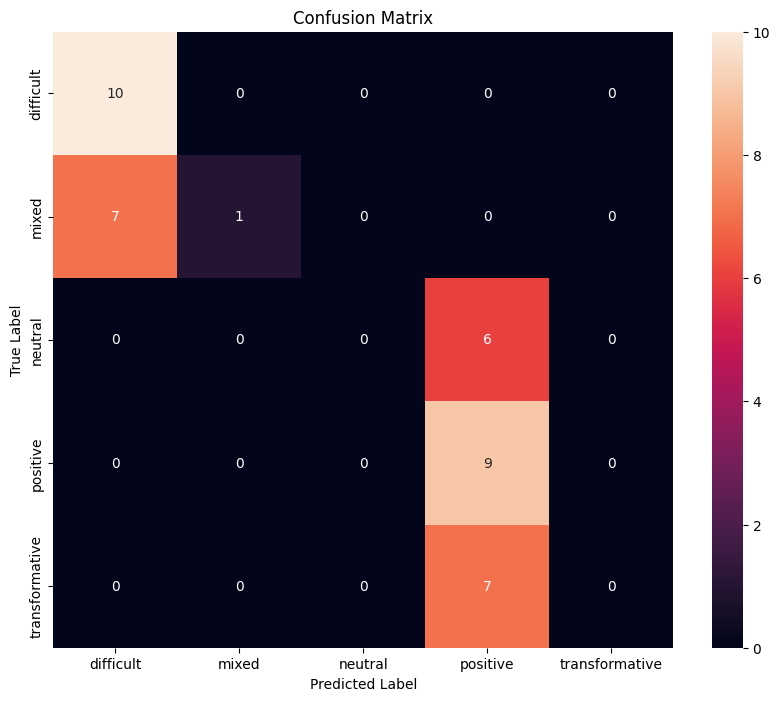


🔄 Training Intensity Classification...


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2962733134.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,1.386000
20,1.384000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

        mild       0.00      0.00      0.00        10
    moderate       0.36      0.75      0.49        12
overwhelming       0.33      0.50      0.40        10
      strong       0.00      0.00      0.00         8

    accuracy                           0.35        40
   macro avg       0.17      0.31      0.22        40
weighted avg       0.19      0.35      0.25        40



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


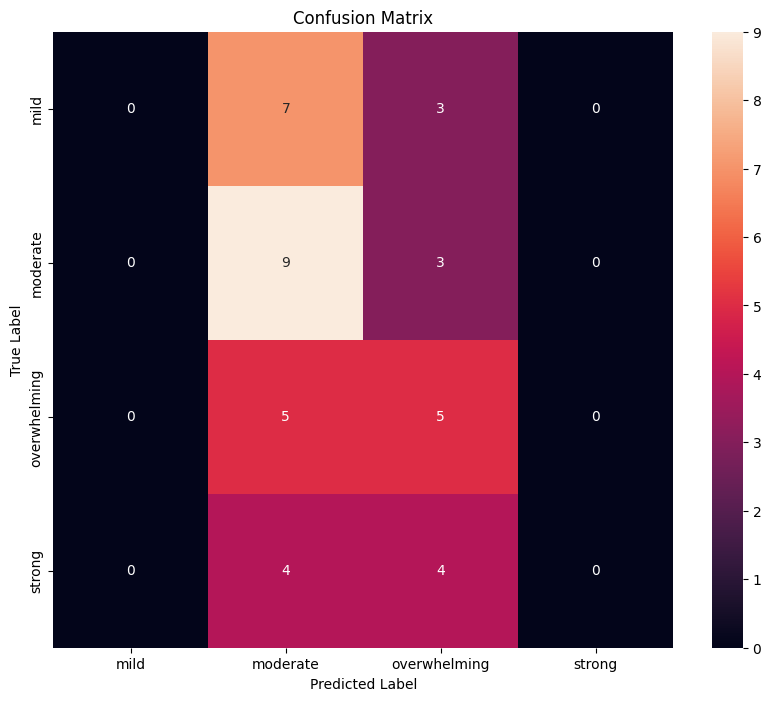


🔄 Training Substance Classification...


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2962733134.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,2.205200
20,2.173700


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

        2C-B       0.00      0.00      0.00         4
   Ayahuasca       1.00      1.00      1.00         5
    Cannabis       0.00      0.00      0.00         4
         DMT       0.00      0.00      0.00         3
    Ketamine       0.00      0.00      0.00         4
         LSD       1.00      0.75      0.86         4
        MDMA       0.00      0.00      0.00         5
   Mescaline       0.00      0.00      0.00         6
  Psilocybin       0.16      1.00      0.27         5

    accuracy                           0.33        40
   macro avg       0.24      0.31      0.24        40
weighted avg       0.24      0.33      0.24        40



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


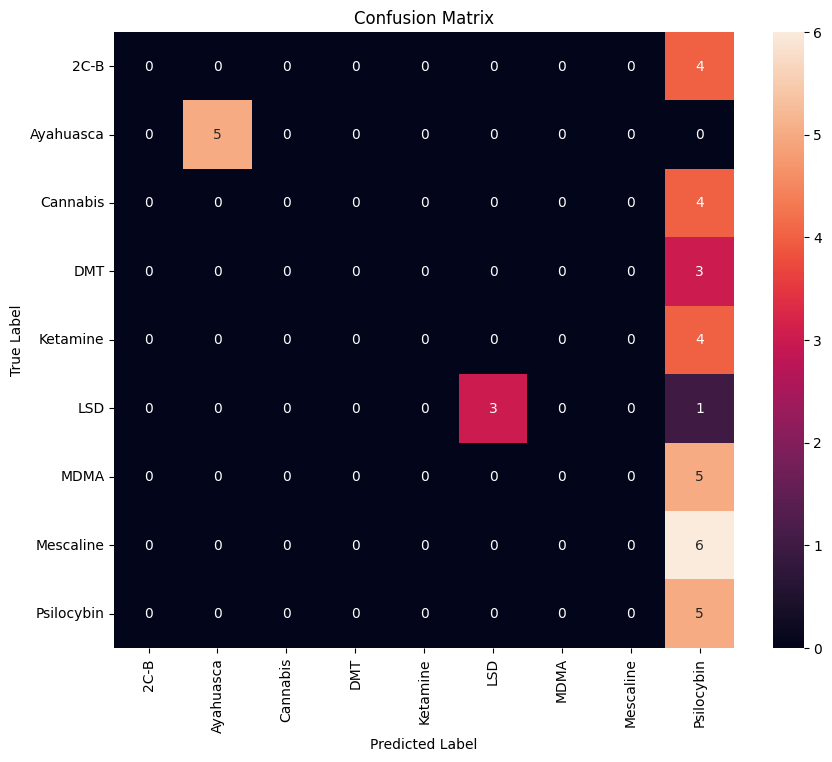


📝 Training Summarization Model...


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3159161722.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training summarization model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Device set to use cpu
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Device set to use cpu
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Device set to use cpu
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Device set to use cpu


=== MODEL ANALYSIS ===

--- Sample 1 ---
Original text (first 200 chars): My experience with LSD was incredible. The visuals were beautiful and I felt a deep connection to nature. The come-up took about 45 minutes and lasted for 6 hours. I experienced enhanced creativity an...


Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Predicted experience type: LABEL_3 (confidence: 0.222)


Your max_length is set to 50, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: my experience with LSD was incredible. The visuals were beautiful and I felt a deep connection to nature.

--- Sample 2 ---
Original text (first 200 chars): This Mescaline trip was a roller coaster. Moments of pure bliss alternated with periods of introspection and mild discomfort. Glad I had a safe setting....
Predicted experience type: LABEL_0 (confidence: 0.233)


Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: This Mescaline trip was a roller coaster. Moments of pure bliss alternated with periods of introspection and mild discomfort.

--- Sample 3 ---
Original text (first 200 chars): My LSD experience was challenging. I felt anxious during the come-up and had some difficult thoughts. However, I learned a lot about myself and felt better after integration. The geometric patterns we...
Predicted experience type: LABEL_0 (confidence: 0.244)


Your max_length is set to 50, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summary: my LSD experience was challenging and I learned a lot about myself and felt better after integration.

--- Sample 4 ---
Original text (first 200 chars): This 2C-B trip was life-changing. I had profound insights about my relationships and felt overwhelming love and compassion. The peak lasted about 2 hours with gentle aftereffects....
Predicted experience type: LABEL_3 (confidence: 0.215)


Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: this 2C-B trip was life-changing. I had profound insights about my relationships .

--- Sample 5 ---
Original text (first 200 chars): This Psilocybin trip was life-changing. I had profound insights about my relationships and felt overwhelming love and compassion. The peak lasted about 2 hours with gentle aftereffects. The natural se...
Predicted experience type: LABEL_3 (confidence: 0.216)


Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: Psilocybin trip lasted about 2 hours with gentle aftereffects .

✅ Training Complete!
Models saved and ready for inference


In [13]:
def main():
    """Main execution workflow"""

    print("🚀 Starting Trip Report NLP Pipeline")
    print("=" * 50)

    # 1. Load and explore data
    df = load_synthetic_data()
    df = explore_data(df)

    # 2. Prepare classification tasks
    classification_tasks = preprocess_for_classification(df)

    # 3. Train classification models
    classification_trainers = {}

    for task_name, task_data in classification_tasks.items():
        print(f"\n🔄 Training {task_data['task_name']}...")

        # Create tokenizer
        tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

        # Create datasets
        datasets = create_datasets(
            task_data['texts'],
            task_data['labels'],
            tokenizer
        )

        # Train model
        trainer, _ = train_classification_model(
            datasets,
            num_labels=len(set(task_data['labels']))
        )

        # Evaluate
        evaluate_classification_model(trainer, datasets['test'], datasets['label_encoder'])

        classification_trainers[task_name] = trainer

    # 4. Train summarization model
    print("\n📝 Training Summarization Model...")
    df_summary = prepare_summarization_data(df)
    summarization_trainer, _ = train_summarization_model(df_summary)

    # 5. Create inference pipelines
    pipelines = create_inference_pipelines(classification_trainers, summarization_trainer)

    # 6. Final analysis
    analyze_results(df, pipelines)

    print("\n✅ Training Complete!")
    print("Models saved and ready for inference")

# Execute when run
if __name__ == "__main__":
    main()